In [1]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

import torch
from torch import nn
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

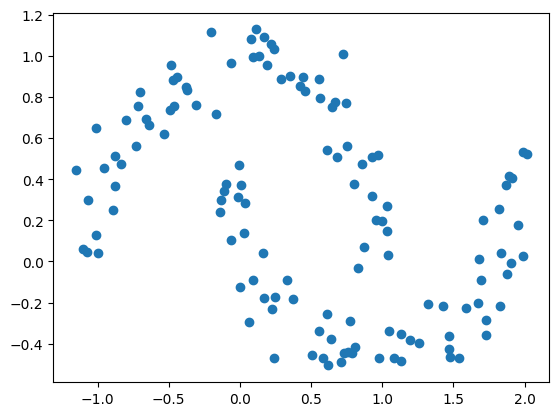

In [2]:
x, y = datasets.make_moons(128, noise=.1)
plt.scatter(x[:, 0], x[:, 1]);

In [3]:
num_layers = 5
base_dist = StandardNormal(shape=[2])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(MaskedAffineAutoregressiveTransform(features=2, 
                                                          hidden_features=4))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

/Users/tarineccleston/Desktop/starccato/starccato-flow/.venv/lib/python3.9/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


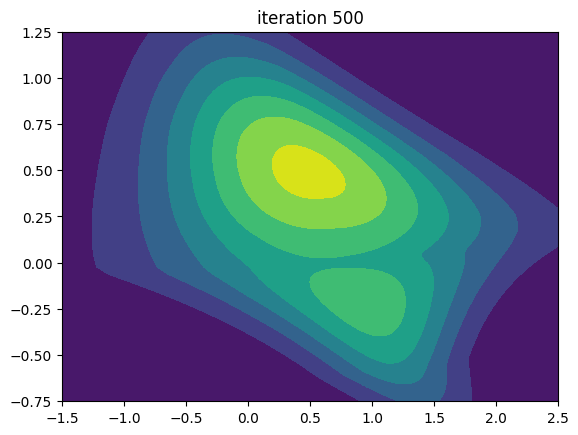

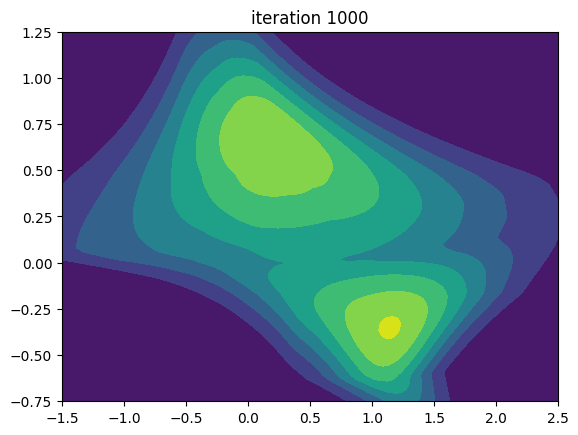

In [4]:
num_iter = 1000
for i in range(num_iter):
    x, y = datasets.make_moons(128, noise=.1)
    x = torch.tensor(x, dtype=torch.float32)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x).mean()
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 500 == 0:
        xline = torch.linspace(-1.5, 2.5, 100)
        yline = torch.linspace(-.75, 1.25, 100)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)

        plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
        plt.title('iteration {}'.format(i + 1))
        plt.show()